

# Waveform Averaging Analysis

<div class="alert alert-info"><h4>Note</h4><p>This tutorial is a mirror of the
          ([MNE tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/plot_70_fnirs_processing.html)_),
          and is reproduced in MNE-NIRS for convenience and so that all
          relevant material is easily accessible to users.</p></div>

This tutorial covers how to convert functional near-infrared spectroscopy
(fNIRS) data from raw measurements to relative oxyhaemoglobin (HbO) and
deoxyhaemoglobin (HbR) concentration, view the average waveform, and
topographic representation of the response.

Here we will work with the `fNIRS motor data <mne:fnirs-motor-dataset>`.


In [40]:
# sphinx_gallery_thumbnail_number = 14

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

In [41]:
import os.path as op
from itertools import compress

import matplotlib.pyplot as plt
import mne
import numpy as np

fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = op.join(fnirs_data_folder, "Participant-1")
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()

Loading C:\Users\bede\mne_data\MNE-fNIRS-motor-data\Participant-1


Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


C:\Users\bede\AppData\Local\Temp\ipykernel_21692\870508878.py:10: RuntimeWarning: Extraction of measurement date from NIRX file failed. This can be caused by files saved in certain locales (currently only ['en_US.utf8', 'de_DE', 'fr_FR', 'it_IT'] supported). Please report this as a github issue. The date is being set to January 1st, 2000, instead of '"Sat, Nov 2, 2019""13:16:16.567"'.
  raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)


<RawNIRX | Participant-1, 56 x 23239 (2974.6 s), ~10.0 MiB, data loaded>

## Providing more meaningful annotation information

First, we attribute more meaningful names to the trigger codes which are
stored as annotations. Second, we include information about the duration of
each stimulus, which was 5 seconds for all conditions in this experiment.
Third, we remove the trigger code 15, which signaled the start and end
of the experiment and is not relevant to our analysis.



In [42]:
raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)

## Viewing location of sensors over brain surface

Here we validate that the location of sources-detector pairs and channels
are in the expected locations. Source-detector pairs are shown as lines
between the optodes, channels (the mid point of source-detector pairs) are
optionally shown as orange dots. Source are optionally shown as red dots and
detectors as black.



In [43]:
subjects_dir = op.join(mne.datasets.sample.data_path(), "subjects")

brain = mne.viz.Brain(
    "fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5"
)
brain.add_sensors(
    raw_intensity.info,
    trans="fsaverage",
    fnirs=["channels", "pairs", "sources", "detectors"],
)
brain.show_view(azimuth=20, elevation=60, distance=400)

False
Channel types::	fnirs_cw_amplitude: 56


## Selecting channels appropriate for detecting neural responses

First we remove channels that are too close together (short channels) to
detect a neural response (less than 1 cm distance between optodes).
These short channels can be seen in the figure above.
To achieve this we pick all the channels that are not considered to be short.



In [44]:
raw_intensity.info

picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks
)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=500, show_scrollbars=False
)

## Converting from raw intensity to optical density

The raw intensity values are then converted to optical density.



In [45]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)

## Evaluating the quality of the data

At this stage we can quantify the quality of the coupling
between the scalp and the optodes using the scalp coupling index. This
method looks for the presence of a prominent synchronous signal in the
frequency range of cardiac signals across both photodetected signals.

In this example the data is clean and the coupling is good for all
channels, so we will not mark any channels as bad based on the scalp
coupling index.



[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

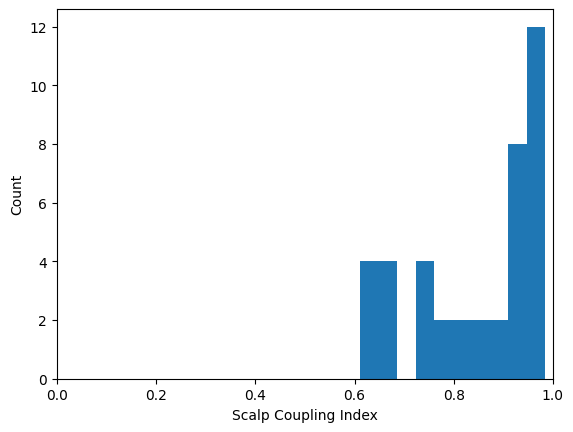

In [46]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])

In this example we will mark all channels with a SCI less than 0.5 as bad
(this dataset is quite clean, so no channels are marked as bad).



In [47]:
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
raw_od.info["bads"] 

[]

At this stage it is appropriate to inspect your data
(for instructions on how to use the interactive data visualisation tool
see `tut-visualize-raw`)
to ensure that channels with poor scalp coupling have been removed.
If your data contains lots of artifacts you may decide to apply
artifact reduction techniques as described in `ex-fnirs-artifacts`.



## Converting from optical density to haemoglobin

Next we convert the optical density data to haemoglobin concentration using
the modified Beer-Lambert law.



In [48]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)

## Removing heart rate from signal

The haemodynamic response has frequency content predominantly below 0.5 Hz.
An increase in activity around 1 Hz can be seen in the data that is due to
the person's heart beat and is unwanted. So we use a low pass filter to
remove this. A high pass filter is also included to remove slow drifts
in the data.



Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


C:\Users\bede\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\bede\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Text(0.5, 0.98, 'After filtering')

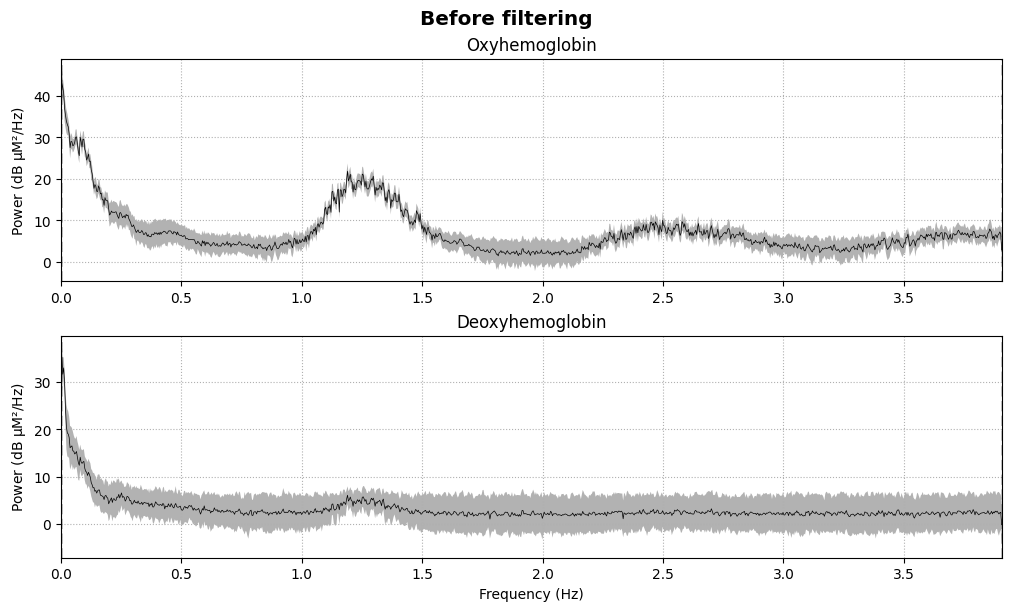

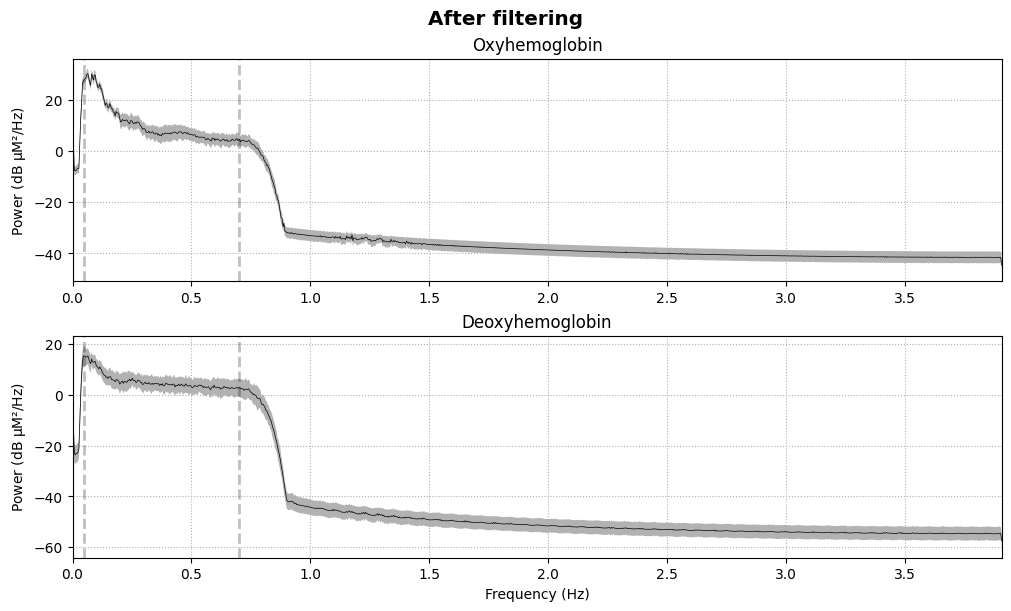

In [49]:
fig = raw_haemo.compute_psd().plot(average=True, amplitude=False)
fig.suptitle("Before filtering", weight="bold", size="x-large")
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
fig = raw_haemo.compute_psd().plot(average=True, amplitude=False)
fig.suptitle("After filtering", weight="bold", size="x-large")

## Extract epochs

Now that the signal has been converted to relative haemoglobin concentration,
and the unwanted heart rate component has been removed, we can extract epochs
related to each of the experimental conditions.

First we extract the events of interest and visualise them to ensure they are
correct.



Used Annotations descriptions: [np.str_('Control'), np.str_('Tapping/Left'), np.str_('Tapping/Right')]


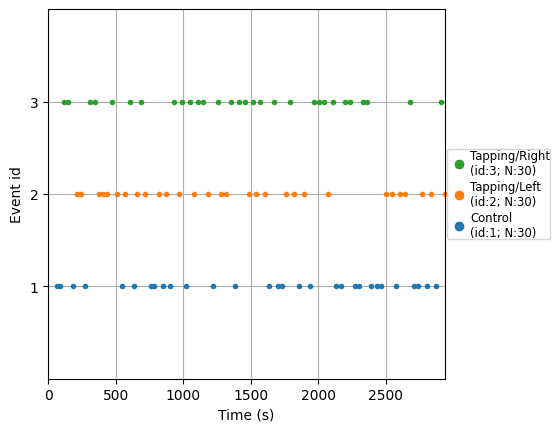

In [50]:
events, event_dict = mne.events_from_annotations(raw_haemo)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info["sfreq"])

Next we define the range of our epochs, the rejection criteria,
baseline correction, and extract the epochs. We visualise the log of which
epochs were dropped.



Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S6_D8 hbo', 'S8_D8 hbo']
6 bad epochs dropped


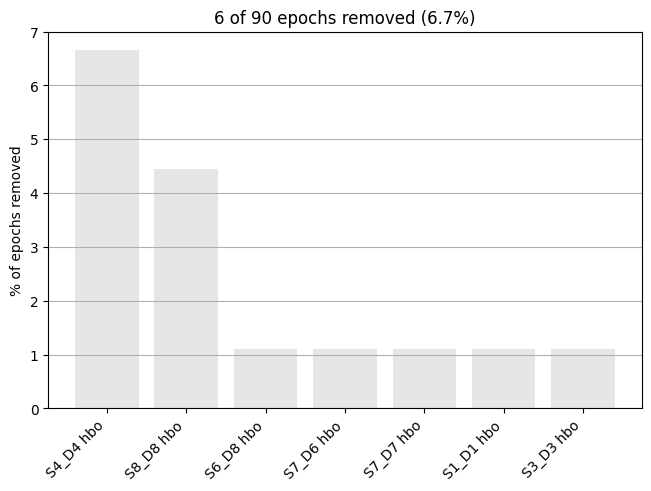

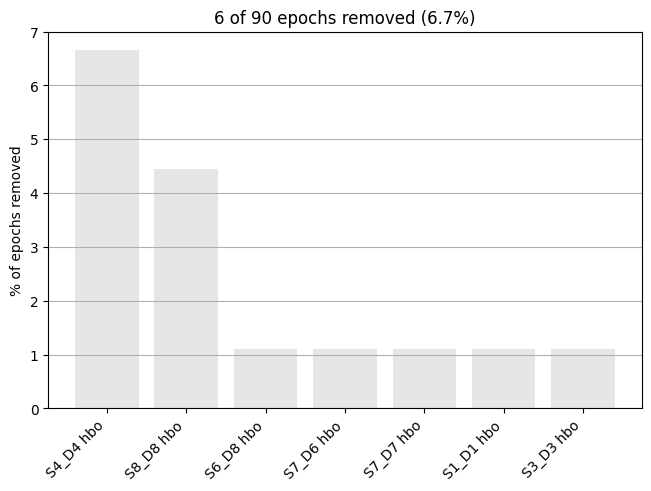

In [51]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)
epochs.plot_drop_log()

## View consistency of responses across trials

Now we can view the haemodynamic response for our tapping condition.
We visualise the response for both the oxy- and deoxyhaemoglobin, and
observe the expected peak in HbO at around 6 seconds consistently across
trials, and the consistent dip in HbR that is slightly delayed relative to
the HbO peak.



Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


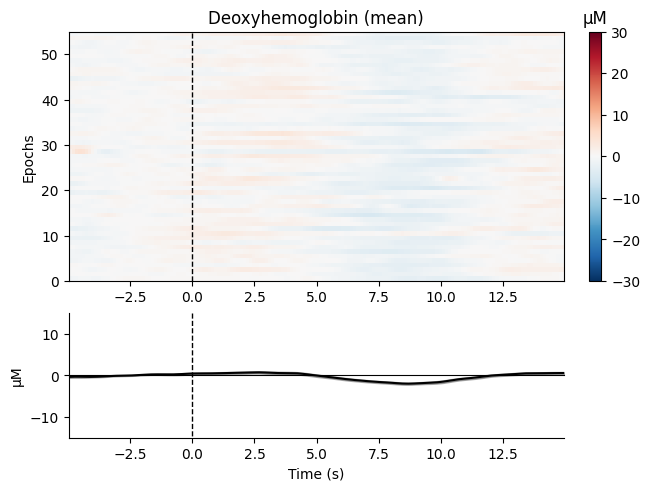

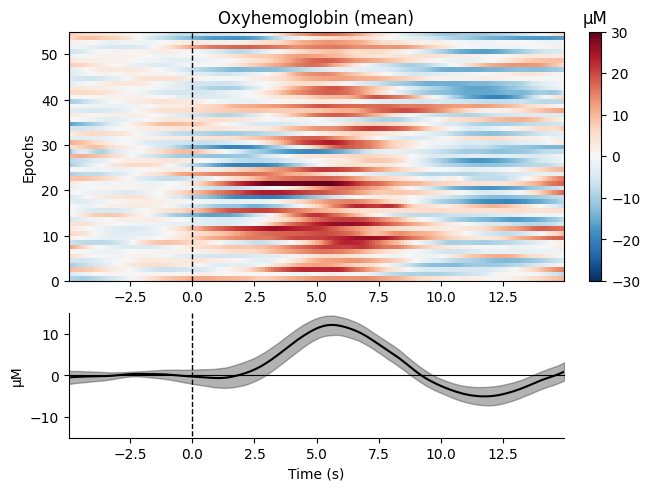

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [52]:
epochs["Tapping"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)

We can also view the epoched data for the control condition and observe
that it does not show the expected morphology.



Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


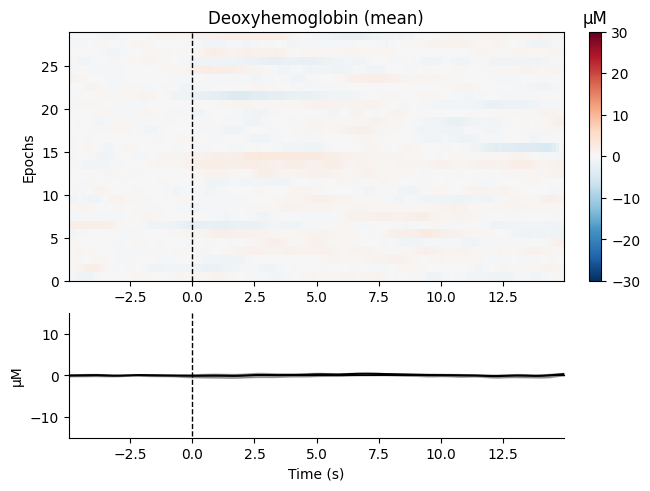

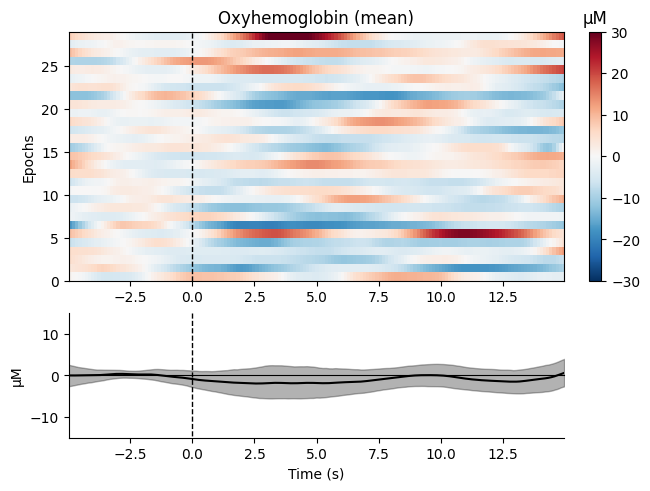

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [53]:
epochs["Control"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)

## View consistency of responses across channels

Similarly we can view how consistent the response is across the optode
pairs that we selected. All the channels in this data are located over the
motor cortex, and all channels show a similar pattern in the data.



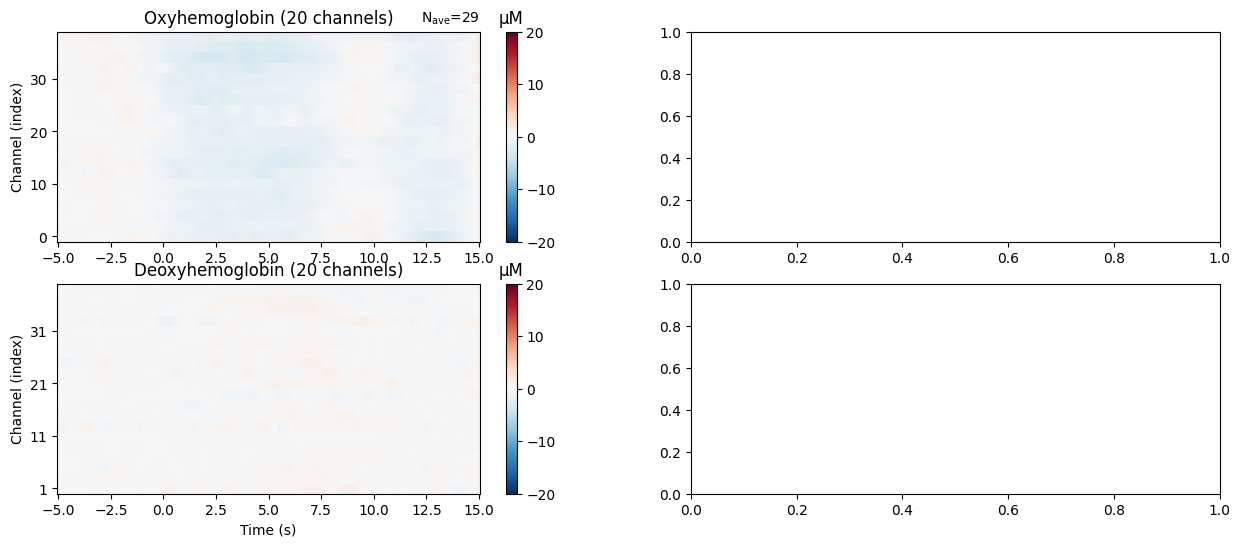

C:\Users\bede\AppData\Roaming\Python\Python312\site-packages\mne\viz\evoked.py:946: UserWarning: Adding colorbar to a different Figure <Figure size 1500x600 with 7 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)
C:\Users\bede\AppData\Roaming\Python\Python312\site-packages\mne\viz\evoked.py:946: UserWarning: Adding colorbar to a different Figure <Figure size 1500x600 with 8 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax)


<Figure size 640x480 with 0 Axes>

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
clims = dict(hbo=[-20, 20], hbr=[-20, 20])
epochs["Control"].average().plot_image(axes=axes[:, 0], clim=clims)
epochs["Tapping"].average().plot_image(axes=axes[:, 1], clim=clims)
for column, condition in enumerate(["Control", "Tapping"]):
    for ax in axes[:, column]:
        ax.set_title(f"{condition}: {ax.get_title()}")

## Plot standard fNIRS response image

Next we generate the most common visualisation of fNIRS data: plotting
both the HbO and HbR on the same figure to illustrate the relation between
the two signals.



combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


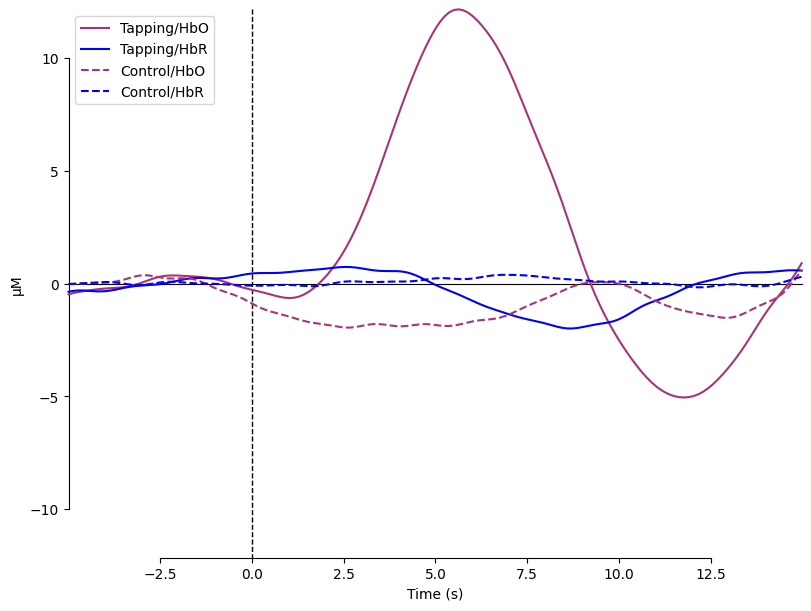

[<Figure size 800x600 with 1 Axes>]

In [55]:
evoked_dict = {
    "Tapping/HbO": epochs["Tapping"].average(picks="hbo"),
    "Tapping/HbR": epochs["Tapping"].average(picks="hbr"),
    "Control/HbO": epochs["Control"].average(picks="hbo"),
    "Control/HbR": epochs["Control"].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(Control=dict(linestyle="dashed"))

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

## View topographic representation of activity

Next we view how the topographic activity changes throughout the response.



No projector specified for this dataset. Please consider the method self.add_proj.


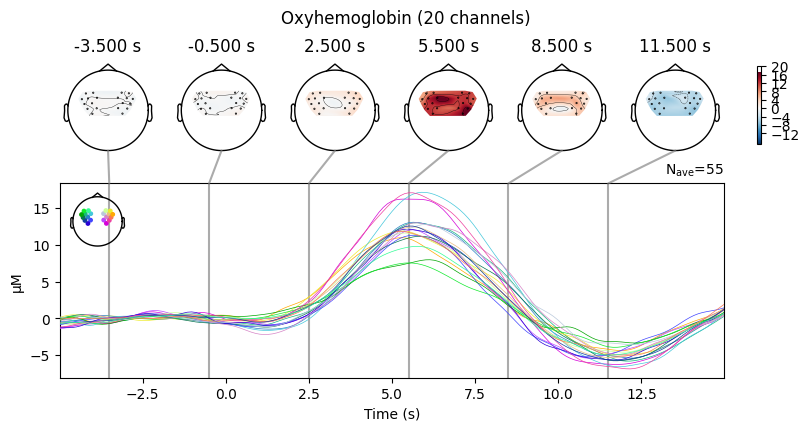

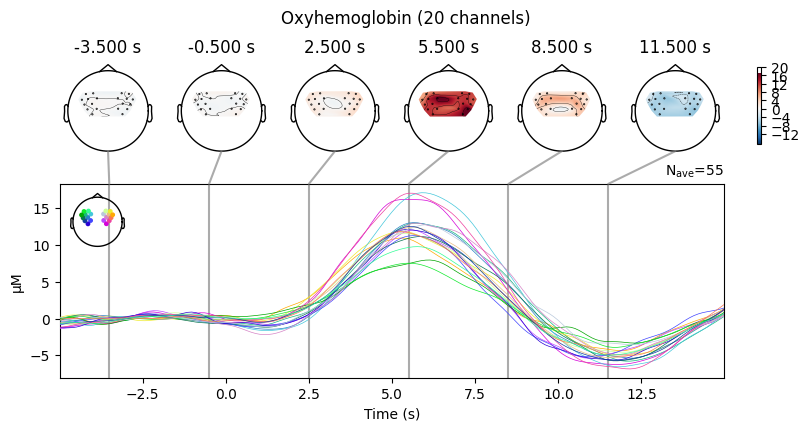

In [56]:
times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate="local")
epochs["Tapping"].average(picks="hbo").plot_joint(
    times=times, topomap_args=topomap_args
)

## Compare tapping of left and right hands

Finally we generate topo maps for the left and right conditions to view
the location of activity. First we visualise the HbO activity.



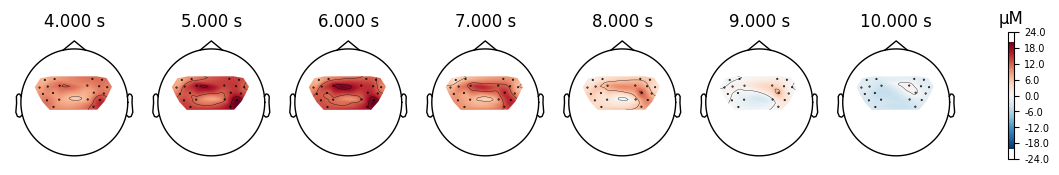

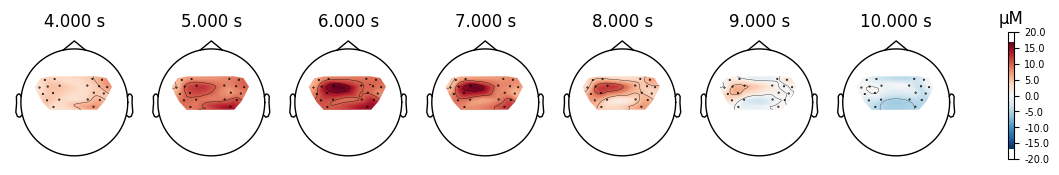

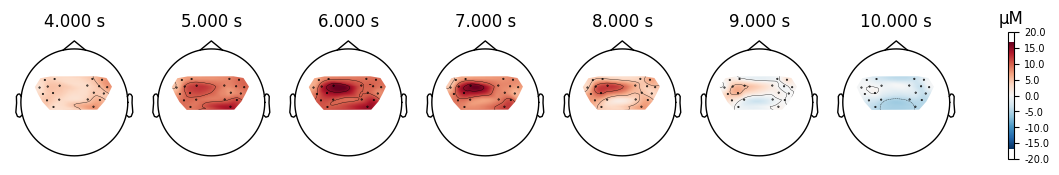

In [57]:
times = np.arange(4.0, 11.0, 1.0)
epochs["Tapping/Left"].average(picks="hbo").plot_topomap(times=times, **topomap_args)
epochs["Tapping/Right"].average(picks="hbo").plot_topomap(times=times, **topomap_args)

And we also view the HbR activity for the two conditions.



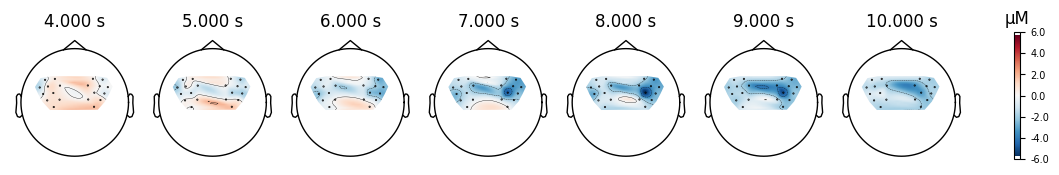

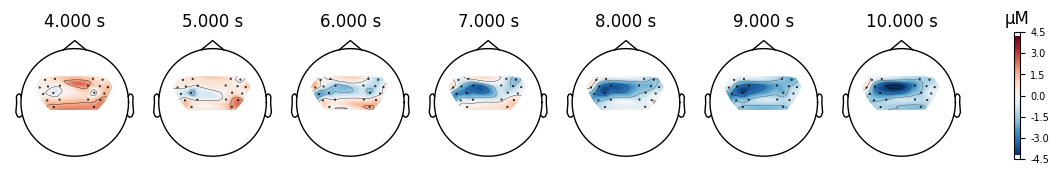

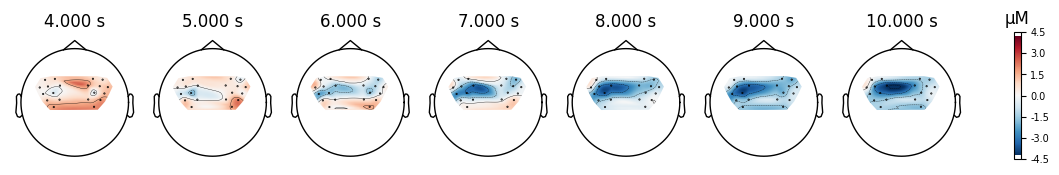

In [58]:
epochs["Tapping/Left"].average(picks="hbr").plot_topomap(times=times, **topomap_args)
epochs["Tapping/Right"].average(picks="hbr").plot_topomap(times=times, **topomap_args)

And we can plot the comparison at a single time point for two conditions.



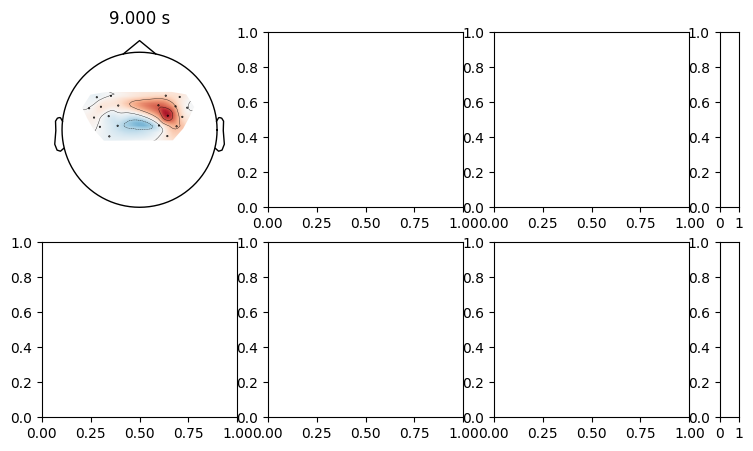

In [59]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(9, 5), gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1])
)
vlim, ts = (-8, 8), 9.0

evoked_left = epochs["Tapping/Left"].average()
evoked_right = epochs["Tapping/Right"].average()

evoked_left.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 0], vlim=vlim, colorbar=False, **topomap_args
)
evoked_left.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 0], vlim=vlim, colorbar=False, **topomap_args
)
evoked_right.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 1], vlim=vlim, colorbar=False, **topomap_args
)
evoked_right.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 1], vlim=vlim, colorbar=False, **topomap_args
)

evoked_diff = mne.combine_evoked([evoked_left, evoked_right], weights=[1, -1])

evoked_diff.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 2:], vlim=vlim, colorbar=True, **topomap_args
)
evoked_diff.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 2:], vlim=vlim, colorbar=True, **topomap_args
)

for column, condition in enumerate(["Tapping Left", "Tapping Right", "Left-Right"]):
    for row, chroma in enumerate(["HbO", "HbR"]):
        axes[row, column].set_title(f"{chroma}: {condition}")

Lastly, we can also look at the individual waveforms to see what is
driving the topographic plot above.



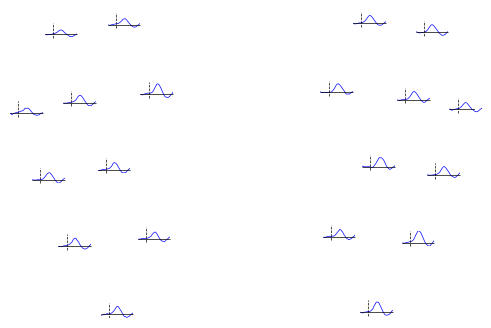

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
mne.viz.plot_evoked_topo(
    epochs["Left"].average(picks="hbo"), color="b", axes=axes, legend=False
)
mne.viz.plot_evoked_topo(
    epochs["Right"].average(picks="hbo"), color="r", axes=axes, legend=False
)

# Tidy the legend:
leg_lines = [line for line in axes.lines if line.get_c() == "b"][:1]
leg_lines.append([line for line in axes.lines if line.get_c() == "r"][0])
fig.legend(leg_lines, ["Left", "Right"], loc="lower right")